# 03 - Predictability & Universe Filtering

### Previously on Stock universe p. s. ...

In our previous efforts to improve generalization and downstream RL performance, we attempted to:
- Apply statistical heuristics to identify "easier" stocks
- Train predictive models to uncover latent structure

While these offered some insight, they lacked **robustness** and **transferability** across time.


### What's next:
We now shift focus toward **meta-characterizing forecastability**, moving beyond surface-level accuracy and toward deeper indicators of *learnability* and *environmental stability*.

#### Meta-Features of Forecasts
I
Instead of evaluating only R² from one-step regressors, we now extract richer *diagnostics from forecast behavior*:

- **Residual Autocorrelation**: Persistence signals underfit
- **ARCH Effects**: Volatility clustering may hint at instability
- **Skew/Kurtosis of Residuals**: Shape mismatches between model and environment
- **Entropy of Forecast Distribution**: High entropy = more chaotic returns

These become meta-features to train models that classify or rank *predictable environments*.


#### Meta-RL Labeling


To ground our theory in agent behavior, we’ll:

1. Train a small RL agent (shallow horizon, simplified environment) on each stock-month
2. Track early performance: Sharpe, alpha, drawdown, or advantage over random
3. Use this as a **proxy label** for "learnability"
4. Aggregate results over time, sectors, and macro states

This creates a **meta-learning dataset** where the labels come from actual agent-environment interactions.


### Pipeline
1. Compute rolling predictability metrics for each ticker
2. Visualize and compare scores across universe and time
3. Select top-N most “learnable” tickers for RL agent
4. Document all decisions, assumptions, and open questions




### Outcome Goal

Identify **which stocks are more “learnable”** in the near future — not just based on past returns, but through the lens of *how models perform on them*.

---

###  Why This Matters

RL agents don’t just need high alpha — they need *structure they can exploit*. This study explores:
- How to measure that structure
- How to learn from past environments
- How to build a filter that works across regimes

---


| Stage                 | Description                                                                                             |
| --------------------- | ------------------------------------------------------------------------------------------------------- |
| 🧹 Preprocessing      | Clean stock OHLCV data, compute lagged returns                                                          |
| 📈 Forecast Models    | Run simple regressors on next-month returns                                                             |
| 🔍 Diagnostics        | Extract residual meta-features, R², forecast entropy, etc.                                              |
| 🧠 Labeling           | - Regression: R² as target<br>- Ranking: (A > B)<br>- RL Reward: agent learnability                     |
| 📊 Feature Extraction | Use summary stats + diagnostic/meta features                                                            |
| 🧬 Modeling           | - Regression: Predict R²<br>- Classification: Predict "learnable"<br>- Contrastive: Rank predictability |
| 🏆 Output             | Sorted top-k stock-months or environments where RL thrives                                              |


| Section                             | Purpose                                                                                                                                                                                                          |
| ----------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 🔧 **Setup & Pipeline Description** | High-level explanation of your RL pipeline, feature engineering, and data sources                                                                                                                                |
| 🧪 **Completed Studies**            | Summary table or list of ablation studies, e.g.:<br>`01 - Reward Function Impact`<br>`02 - Predictability Filters via R²`<br>`03 - Meta-Learnability Scores`                                                     |
| ✅ **Conclusions So Far**            | Bullet points of key findings from each experiment, e.g.:<br>– Simple R² doesn't generalize across time<br>– Residual-based features offer better stability<br>– Meta-RL proxy labels correlate with test Sharpe |
| 🔬 **Ongoing Work**                 | One-liner of what’s running or planned, so future you remembers                                                                                                                                                  |
| 📎 **Notebook Index**               | List of notebooks and what each one covers                                                                                                                                                                       |


We start with both:

First, build the regression pipeline → quick wins, visualization, baseline.

Then, shift to contrastive ranking → build a PairwiseMetaDataset, use XGBoostRanker or SiameseNet.

Ready to begin with the regression version using:

LinearReg + RF residuals

Autocorr / Ljung-Box / ARCH tests

Predict next-month R²?



In [2]:
# SETUP: Imports & Paths ===========================
import jupyter

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from src.utils.system import boot, Notify
from src.data.feature_pipeline import basic_chart_features,load_base_dataframe
from src.predictability.easiness import rolling_sharpe, rolling_r2, rolling_info_ratio, rolling_autocorr
from src.predictability.pipeline import generate_universe_easiness_report
from IPython import display
from src.utils.system import boot,notify
from src.experiments.experiment_tracker import ExperimentTracker



from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, acovf


import warnings
warnings.filterwarnings("ignore")


In [3]:
experience_name = "stock_universe_predictability_selection__MetaFeatures__MetaRlLabeling"

excluded_tickers=['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV']
excluded_tickers.sort()
config={
    "regressor":"RandomForestRegressor",
    "n_estimators": 100,
    "random_state":42
}
run_settings={
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date":"2022-01-01",
    "end_date":"2022-07-01"
}


In [37]:
# LOAD OHLCV ==========================================
ohlcv_df = load_base_dataframe()
ohlcv_df.tail()
_ohlcv=ohlcv_df.copy()

In [5]:
# BASIC PREPROCESSING ===================================
excluded_tickers = run_settings["excluded_tickers"]
min_samples = run_settings["min_samples"]
cv_folds = run_settings["cv_folds"]
lags = run_settings["lags"]
start_date = run_settings["start_date"]
end_date = run_settings["end_date"]

# CROP THE SAMPLE =======================================
tickers = ohlcv_df['symbol'].unique()[:100]
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL","MSFT","JPM","V",'LLY','UNH','AMZN','TSLA','META','GOOGL','GE','UBER','COST','WMT','XOM','CVX'.'NEE','SO','AMT','PLD','LIN','SHW']

# FOR POC ONLY


ohlcv_df = ohlcv_df.copy()
ohlcv_df['date'] = pd.to_datetime(ohlcv_df['date'])
ohlcv_df = ohlcv_df[(ohlcv_df['date'] >= start_date) & (ohlcv_df['date'] < end_date)]
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)


In [6]:
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

In [7]:
#ohlcv_df.sort_values(by="date").head().to_csv('ohlcv_to_upload.csv')

## Quick Recap
We want to estimate how "predictable" each stock is in a given month, using meta-features of its behavior.

#### Pipeline: 
**Loop: For each (stock, month)**
From Previous Month (t) we will extract features. From the returns in month t, we compute:
* Mean
* Std 
* Skew 
* Kurtosis
* Entropy of returns
* Mean of volumne
* Std of volume

These become the meta-features for that stock-month.

**From Following Month (t+1) we will compute "predictability"**

* With 5 lags of daily returns from month t+1 will try to predict daily returns using a RandomForestRegressor
* Evaluate performance with cross-validated R² (cv_r2)
* Analyze residuals from this model with the Ljung–Box test for autocorrelation ⇒ gives ljung_pval

These become the target labels or diagnostic scores

| Feature                 | Description                                        |
| ----------------------- | -------------------------------------------------- |
| `resid_acf1`            | Autocorrelation of residuals (lag 1)               |
| `resid_std`             | Std of residuals                                   |
| `resid_skew`            | Skewness of residuals                              |
| `resid_kurtosis`        | Kurtosis of residuals                              |
| `resid_ljung_pval`      | p-value of Ljung-Box test for residual autocorr    |
| `return_autocorr_1d`    | Lag-1 autocorrelation of raw 1D returns            |
| `volatility_clustering` | Rolling std autocorrelation (vol clustering proxy) |


In [20]:
# FEATURE + LABEL EXTRACTION ============================
features, targets, metadata = [], [], []
def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]
    
for symbol in tqdm(tickers):

    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df['month'] = df['date'].dt.to_period('M')
    months = df['month'].unique()
  
    for i in range(1, len(months)):
        m_t = months[i-1]
        m_t1 = months[i]

        df_t = df[df['month'] == m_t]
        df_t1 = df[df['month'] == m_t1]
        
        if len(df_t1) < min_samples:
            continue
        
        # Feature engineering from month t ---
        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),#r1d.mean(),
            'std_return': r1d.std(),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
            'vol_mean': mean_policy(v),#v.mean(),
            'vol_std': v.std()
        }

        # Residual diagnostics from simple RF on t+1
        df_lag = df_t1.copy()
        
        for lag in range(1,  run_settings['lags'] + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
            
       
        df_lag = df_lag.dropna()
        if len(df_lag) < min_samples:
            continue
        
        
        
        X = df_lag[[f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
        model.fit(X, y)
        
        residuals = y - model.predict(X)
                
        # Meta-diagnostics ---
        ljung_pval = acorr_ljungbox(residuals, lags=[run_settings['lags']], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        # Predictability label (cross-val R²) ---
        cv_r2 = mean_policy(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))#.mean()
        #print({"cv_r2":cv_r2,"ljung_pval":ljung_pval})
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


100%|██████████| 100/100 [05:56<00:00,  3.57s/it]


In [21]:
# BUILD DTASETS ============================================
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name='cv_r2')
meta_df = pd.DataFrame(metadata, columns=['symbol', 'month'])


X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

,symbol,month_str,mean_return,std_return,skew,kurtosis,entropy,vol_median,vol_std,trend_r2,acf_lag_1,acf_lag_2,acf_lag_3,acf_lag_4,acf_lag_5,ljung_pval
0,AAPL,2022-01,-0.004864,0.021790,1.853444,3.843952,1.732552,103899632.0,2.837221e+07,0.871593,0.364593,0.077420,-0.051653,-0.136926,-0.145906,0.567336
1,AAPL,2022-02,-0.001389,0.014507,0.050183,-1.127513,1.995922,93258667.0,1.843377e+07,0.857676,0.202750,-0.456040,-0.375859,-0.047999,0.135575,0.924329
2,AAPL,2022-03,0.005037,0.019492,-0.057035,-1.302837,2.088092,104410428.0,1.763456e+07,0.827672,0.166238,-0.084731,-0.107566,0.243593,0.290095,0.503794
3,AAPL,2022-04,-0.001592,0.020859,0.347075,-0.249996,2.082007,84133031.5,1.924501e+07,0.748626,-0.316736,-0.339796,0.288475,-0.112246,-0.104272,0.879839
4,AAPL,2022-05,0.001747,0.030345,-0.292421,-0.916975,2.070493,121269886.0,2.461844e+07,0.752987,-0.194864,0.023925,-0.245395,0.253852,0.106068,0.999512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,SHW,2022-07,0.003364,0.027952,-1.336802,3.651716,1.639957,1459465.0,1.358882e+06,0.818555,-0.051512,-0.042771,-0.170669,-0.156752,0.079851,0.425632
238,SHW,2022-08,-0.004158,0.020341,0.492825,-0.071426,1.971333,1569652.0,4.264905e+05,0.741818,-0.234639,0.314646,-0.175631,0.023254,-0.271657,0.864652
239,SHW,2022-09,-0.008767,0.019780,0.341255,0.683358,1.938465,1564374.0,4.324850e+05,0.806586,-0.002034,-0.041285,0.075614,-0.421356,0.037303,0.971965
240,SHW,2022-10,0.003088,0.024471,-0.293090,-0.485193,2.070493,1753626.0,4.279297e+05,0.824056,0.080892,-0.056183,-0.125110,-0.241096,0.120686,0.741019


In [44]:
# TIME-BASED TRAIN/TEST SPLIT ===============================


X_df['month_dt'] = pd.to_datetime(X_df['month_str'])

split_date = unique_months[int(0.8 * len(unique_months))]

train_mask = X_df['month_dt'] < split_date
test_mask = X_df['month_dt'] >= split_date

X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
y_train, y_test = y_df[train_mask], y_df[test_mask]
meta_test = meta_df[test_mask.values].copy()

In [76]:
# REGRESSOR TRAINING ========================================
import xgboost as xgb
#final_model = RandomForestRegressor(n_estimators=config['n_estimators'], random_state=config['random_state'])
final_model = RandomForestRegressor(n_estimators=500, random_state=config['random_state'])

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


Test RMSE: 0.6914, R²: -0.0405
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
93    META  2022-06 -0.708509     -0.216626
240    SHW  2022-10 -0.523224     -0.241169
85    TSLA  2022-09 -0.295166     -0.265516
20    MSFT  2022-10 -0.148575     -0.291808
75    AMZN  2022-10 -0.728373     -0.303888
70    AMZN  2022-05 -0.533450     -0.305479
81    TSLA  2022-05 -0.369287     -0.348150
164    XOM  2022-11 -0.619872     -0.365136
213    PLD  2022-05 -0.429693     -0.369293
95    META  2022-08 -0.580593     -0.375788


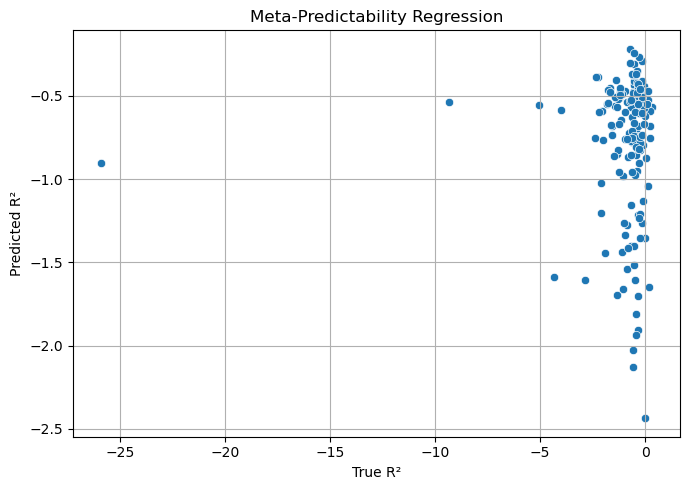

In [77]:
# REGRESSION RESULTS ========================================
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_policy((y_test - y_pred)**2))

print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred

top = meta_test.sort_values('predicted_r2', ascending=False).head(10)
print("Top predictable stock-months:")
print(top)

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

# ONLY ON FINAL MODEL
# 100 - Test RMSE: 1.2389, R²: -0.1142
# 300 - Test RMSE: 1.2394, R²: -0.1150 
# 500 - Test RMSE: 1.2317, R²: -0.1013

# WITH MEDIAN AND ROBUST
# 500 - Test RMSE: 0.4345, R²: -0.1013

# WITH EWM
# 500 - Test RMSE: 1.5385, R²: -0.0056

In [ ]:
xxxxxxxxxx

100%|██████████| 22/22 [02:17<00:00,  6.27s/it]


Test RMSE: 4.9117, R²: -17.7307
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
218    PLD  2022-10  0.185921     -0.619568
207    AMT  2022-10 -0.887087     -0.761770
213    PLD  2022-05 -0.627813     -0.777694
196     SO  2022-10 -0.590242     -0.966158
203    AMT  2022-06 -0.576997     -0.988193
219    PLD  2022-11 -0.643562     -1.030439
195     SO  2022-09 -0.540650     -1.044959
206    AMT  2022-09 -1.637163     -1.066930
228    LIN  2022-09 -0.434680     -1.075967
227    LIN  2022-08 -0.761476     -1.109294


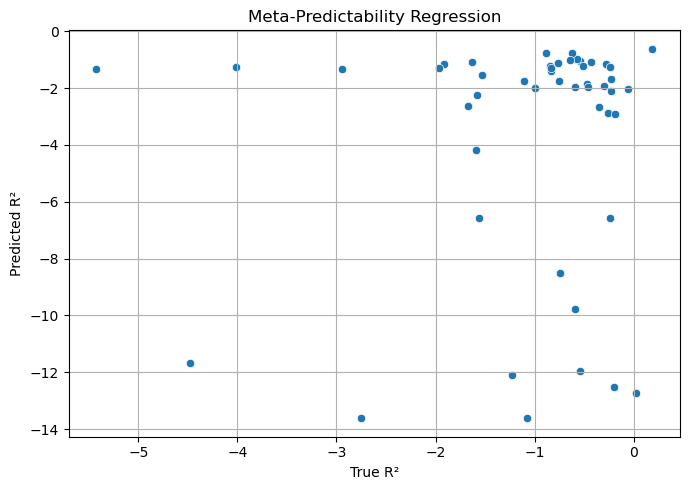

In [79]:
# Predictability Meta-Feature Pipeline with Structural Diagnostics

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
min_samples = 10
cv_folds = 3
lag_window = 5

# === DATA ===
df = ohlcv_df[(ohlcv_df['date'] >= "2022-01-01") & (ohlcv_df['date'] < "2023-01-01")].copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
df['return_1d'] = df['return_1d'].fillna(0)
df.drop(columns=["sector_id", "industry_id"], inplace=True)

# === TICKERS ===
tickers = ["AAPL", "MSFT", "JPM", "V", 'LLY', 'UNH', 'AMZN', 'TSLA', 'META', 'GOOGL',
           'GE', 'UBER', 'COST', 'WMT', 'XOM', 'CVX', 'NEE', 'SO', 'AMT', 'PLD', 'LIN', 'SHW']



features, targets, metadata = [], [], []

def mean_policy(arr):
    #return np.median(arr)
    return pd.Series(arr).ewm(span=5).mean().iloc[-1]

# === FEATURE + LABEL EXTRACTION ===
for symbol in tqdm(tickers):
    symbol_df = df[df['symbol'] == symbol].sort_values('date').copy()
    months = symbol_df['month'].unique()

    for i in range(1, len(months)):
        m_t = months[i - 1]
        m_t1 = months[i]

        df_t = symbol_df[symbol_df['month'] == m_t].copy()
        df_t1 = symbol_df[symbol_df['month'] == m_t1].copy()

        if len(df_t1) < min_samples:
            continue

        r1d = df_t['return_1d'].astype(float).values
        v = df_t['volume'].astype(float).values

        hist = np.histogram(r1d, bins=10, density=True)[0] + 1e-8
        acf_vals = acf(r1d, nlags=5, fft=True)[1:6]  # exclude lag 0
        acf_names = {f'acf_lag_{i+1}': val for i, val in enumerate(acf_vals)}

        time_idx = np.arange(len(r1d)).reshape(-1, 1)
        try:
            trend_r2 = RandomForestRegressor().fit(time_idx, r1d).score(time_idx, r1d)
        except:
            trend_r2 = 0

        feat = {
            'symbol': symbol,
            'month_str': str(m_t),
            'mean_return': mean_policy(r1d),
            'std_return': np.std(r1d),
            'skew': skew(r1d),
            'kurtosis': kurtosis(r1d),
            'entropy': entropy(hist),
            'vol_median': mean_policy(v),
            'vol_std': np.std(v),
            'trend_r2': trend_r2,
            **acf_names
        }

        # Residual diagnostics on t+1
        df_lag = df_t1.copy()
        for lag in range(1, lag_window + 1):
            df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag = df_lag.dropna()

        if len(df_lag) < min_samples:
            continue

        X = df_lag[[f'return_lag_{i}' for i in range(1, lag_window + 1)]].values
        y = df_lag['return_1d'].values

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        residuals = y - model.predict(X)

        ljung_pval = acorr_ljungbox(residuals, lags=[lag_window], return_df=True).iloc[0]['lb_pvalue']
        feat['ljung_pval'] = ljung_pval

        cv_r2 = np.mean(cross_val_score(model, X, y, cv=cv_folds, scoring='r2'))
        features.append(feat)
        targets.append(cv_r2)
        metadata.append((symbol, str(m_t)))


Test RMSE: 4.9117, R²: -17.7307
Top predictable stock-months:
    symbol    month   true_r2  predicted_r2
218    PLD  2022-10  0.185921     -0.619568
207    AMT  2022-10 -0.887087     -0.761770
213    PLD  2022-05 -0.627813     -0.777694
196     SO  2022-10 -0.590242     -0.966158
203    AMT  2022-06 -0.576997     -0.988193
219    PLD  2022-11 -0.643562     -1.030439
195     SO  2022-09 -0.540650     -1.044959
206    AMT  2022-09 -1.637163     -1.066930
228    LIN  2022-09 -0.434680     -1.075967
227    LIN  2022-08 -0.761476     -1.109294


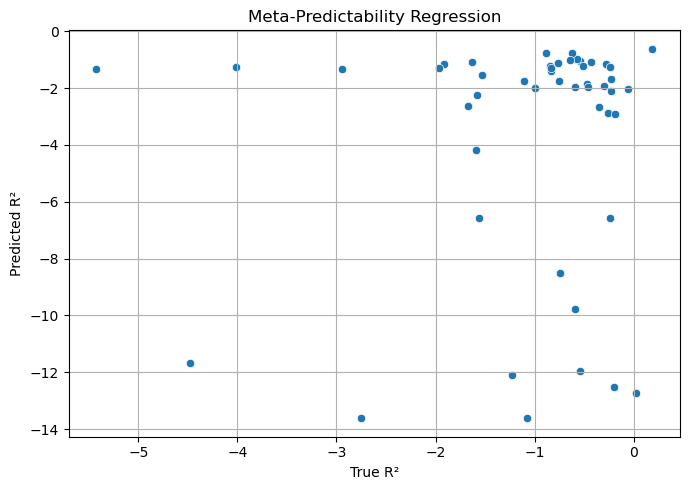

In [81]:

# === DATAFRAME PREP ===
X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name="cv_r2")
X_df['month_dt'] = pd.to_datetime(X_df['month_str'])
meta_df = pd.DataFrame(metadata, columns=["symbol", "month"])
X = X_df.drop(columns=['symbol', 'month_str', 'month_dt'])

# === SCALING ===
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# === SPLIT ===
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_df[:split_idx], y_df[split_idx:]
meta_test = meta_df.iloc[split_idx:].copy()

# === REGRESSOR TRAINING ===
final_model = RandomForestRegressor(n_estimators=500, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# === METRICS ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}, R²: {r2:.4f}")

meta_test['true_r2'] = y_test.values
meta_test['predicted_r2'] = y_pred
print("Top predictable stock-months:")
print(meta_test.sort_values('predicted_r2', ascending=False).head(10))

# === VISUALIZATION ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("True R²")
plt.ylabel("Predicted R²")
plt.title("Meta-Predictability Regression")
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
# === Contrastive Dataset Builder ===
import random
from sklearn.utils import shuffle


def build_contrastive_dataset(X, y, meta, n_pairs=20000, margin=0.02):
    X_pairs = []
    y_pairs = []
    meta_pairs = []

    num_samples = len(y)
    attempts = 0
    max_attempts = n_pairs * 10

    while len(X_pairs) < n_pairs and attempts < max_attempts:
        i, j = np.random.choice(num_samples, size=2, replace=False)
        r2_i, r2_j = y[i], y[j]

        diff = r2_i - r2_j
        if abs(diff) < margin:
            attempts += 1
            continue

        if diff > 0:
            X_diff = X[i] - X[j]
            y_label = 1
        else:
            X_diff = X[j] - X[i]
            y_label = 0

        X_pairs.append(X_diff)
        y_pairs.append(y_label)
        meta_pairs.append((meta.iloc[i].to_dict(), meta.iloc[j].to_dict()))
        attempts += 1

    return np.array(X_pairs), np.array(y_pairs), meta_pairs

# === Contrastive Model ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def train_contrastive_model(X_pairs, y_pairs):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_pairs, y_pairs)
    return clf


# === Scoring Function from Single Sample ===
class ScoringWrapper:
    def __init__(self, model):
        self.model = model

    def score(self, x):
        # Compare x to 0-vector (neutral baseline)
        x = x.reshape(1, -1)
        return self.model.decision_function(x)[0]


# === Example Usage ===
# X_scaled, y_df, meta_df assumed to exist

X_pairs, y_pairs, meta_pairs = build_contrastive_dataset(X_scaled, y_df.values, meta_df, n_pairs=20000, margin=0.02)
print("Class distribution:", np.bincount(y_pairs))

contrastive_model = train_contrastive_model(X_pairs, y_pairs)
scorer = ScoringWrapper(contrastive_model)
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores

# Score individual months:
scores = [scorer.score(x) for x in X_scaled]
meta_df['score'] = scores
meta_df['true_r2'] = y_df.values
# Top predictable stock-months by contrastive model:
top_ranked = meta_df.sort_values('score', ascending=False).head(10)
print(top_ranked)


Class distribution: [ 9967 10033]
    symbol    month     score    true_r2
1     AAPL  2022-02  0.167660  -2.391725
84    TSLA  2022-08  0.143005  -1.018681
3     AAPL  2022-04  0.121884  -0.783627
71    AMZN  2022-06  0.119581  -0.206225
8     AAPL  2022-09  0.110810  -1.743733
13    MSFT  2022-03  0.095753  -0.760031
25     JPM  2022-04  0.091321  -5.843308
210    PLD  2022-02  0.090479  -0.279033
32     JPM  2022-11  0.087494 -21.387389
4     AAPL  2022-05  0.085433  -1.125503


In [89]:
top = meta_df.sort_values("score", ascending=False).head(10)
bottom = meta_df.sort_values("score", ascending=True).head(10)

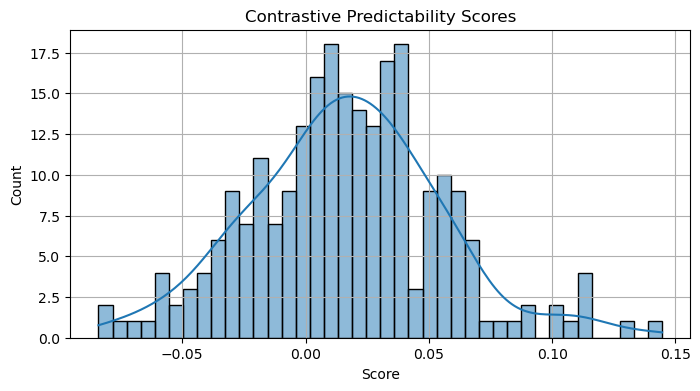

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(meta_df['score'], bins=40, kde=True)
plt.title("Contrastive Predictability Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

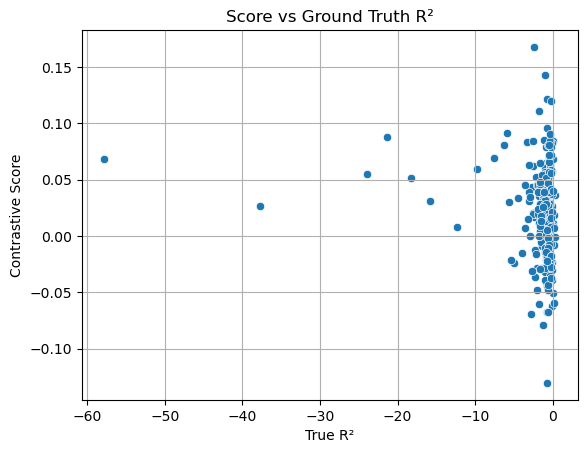

In [95]:
sns.scatterplot(data=meta_df, x='true_r2', y='score')
plt.xlabel("True R²")
plt.ylabel("Contrastive Score")
plt.title("Score vs Ground Truth R²")
plt.grid(True)
plt.show()

In [93]:
xxxxxxxxxxxxxxxxxxxxx

0     -0.346768
1     -2.391725
2     -0.797673
3     -0.783627
4     -1.125503
         ...   
237   -5.422301
238   -0.199645
239   -1.076902
240   -1.224698
241    0.021795
Name: cv_r2, Length: 242, dtype: float64

In [165]:
# Agent-Based Meta-Labeling (Advantage Estimation)
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
import warnings
warnings.filterwarnings("ignore")
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
# === ADVANTAGE FUNCTION ===
def compute_agent_advantage(df, symbol, month_str):
    df_symbol = df[df['symbol'] == symbol].copy()
    df_symbol['month'] = df_symbol['date'].dt.to_period("M")
    df_month = df_symbol[df_symbol['month'] == pd.Period(month_str)]
    df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1]

    if len(df_next) < min_samples:
        return np.nan

    try:
        # Define environment
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d','symbol']].copy()
        env_df.rename(columns={'symbol':"tic"},inplace=True)
        env_df = env_df.reset_index(drop=True)
        stock_dim = 1
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": 0.001,
            "sell_cost_pct": 0.001,
            "state_space": 6 * stock_dim + 1,
            "stock_dim": stock_dim,
            "tech_indicator_list": ["return_1d"],
            "action_space": stock_dim,
            "reward_scaling": 1e-4,
          "num_stock_shares":1
        }
        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: WrappedStockTradingEnv(df=env_df, **env_kwargs)])
        # Train PPO Agent
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=5000)

        # Evaluate
        obs = env.reset()
        total_reward_agent = 0
        total_reward_random = 0

        for _ in range(len(env_df)):
            action, _states = model.predict(obs)
            obs, rewards, dones, info = env.step(action)
            total_reward_agent += float(rewards)

        # Evaluate random policy
        obs = env.reset()
        for _ in range(len(env_df)):
            action = env.action_space.sample()
            obs, rewards, dones, info = env.step(action)
            total_reward_random += float(rewards)

        advantage = total_reward_agent - total_reward_random
        return advantage

    except Exception as e:
        print(f"Advantage error for {symbol}-{month_str}: {e}")
        return np.nan

# === COMPUTE ADVANTAGE FOR META-DF ===
meta_df['advantage'] = meta_df.apply(lambda row: compute_agent_advantage(df, row['symbol'], row['month']), axis=1)

# === ADVANTAGE RESULTS ===
print("Top agent-advantaged stock-months:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# === Save Results (Optional) ===
# meta_df.to_csv("predictability_meta_results.csv", index=False)


Advantage error for AAPL-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-07: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-09: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AAPL-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for 

Advantage error for META-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for META-2022-11: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-07: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for GOOGL-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage er

Advantage error for SO-2022-08: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-09: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-10: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for SO-2022-11: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-01: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-02: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-03: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-04: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-05: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-06: could not broadcast input array from shape (4,) into shape (7,)
Advantage error for AMT-2022-07: c

In [ ]:
# === Agent-Based Meta-Labeling: Advantage Estimation ===
import pandas as pd
import numpy as np
import gym
import warnings
import time
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

warnings.filterwarnings("ignore")

# === PPO Utility Functions ===

class WrappedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        # Call the original step method
        state, reward, _,done, info = super().step(actions)

        # Wrap the reward in a NumPy array so DummyVecEnv works properly
        if not isinstance(reward, (list, np.ndarray)):
            reward = np.array([reward])
        
        return state, reward, done, info
    
class PatchedStockTradingEnv(StockTradingEnv):
    def step(self, actions):
        #print('pst', actions)
        obs, reward, done,truncated, info = super().step(actions)
        #print('pst2')
        reward = np.array([reward], dtype=np.float32)
        done = np.array([done])
        info = [info]
        
        # SB3 expects 5 items: obs, reward, terminated, truncated, info
        info = {"dummy": True}
        return obs, reward, done, done, info
    
def train_ppo_agent(env, timesteps=5000):

    model = PPO("MlpPolicy", env, verbose=0)
  
    model.learn(total_timesteps=timesteps)

    return model
def evaluate_policy(env, model, steps):
    obs = env.reset()
    total_reward = 0

    for _ in range(steps):
       
        action, _ = model.predict(obs)
     
        truncated = False
        obs, rewards, terminated, info = env.step(action)

        done = terminated or truncated
     
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    #print('xxx 5',total_reward)
    return total_reward

def evaluate_random(env, steps):
    #print('x')
    obs = env.reset()
    #print('x1',steps)
    total_reward = 0
    for _ in range(steps):
        #print('x2',env.action_space.sample())
        action = env.action_space.sample()
        #print('x3',action)
        truncated = False
        #print('x4',env.step(np.array([action]).astype(np.float32)))
        obs, rewards, terminated, info = env.step(np.array([action]).astype(np.float32))
        #print('x5',rewards)
        done = terminated or truncated
        #print(f"Type of rewards: {type(rewards)}, value: {rewards}")
        total_reward += float(np.squeeze(rewards))
        if done:
            break
    return total_reward


# === ADVANTAGE FUNCTION ===

def compute_agent_advantage(df, symbol, month_str, min_samples=10):
    try:
        #print(month_str)
        df_symbol = df[df['symbol'] == symbol].copy()
        df_symbol['month'] = df_symbol['date'].dt.to_period("M")
        df_next = df_symbol[df_symbol['month'] == pd.Period(month_str) + 1].copy()
        #print(1)
        if len(df_next) < min_samples:
            return np.nan

        # Prepare DataFrame for env
        df_next.rename(columns={"symbol": "tic"}, inplace=True)
        env_df = df_next[['date', 'open', 'high', 'low', 'close', 'volume', 'return_1d', 'tic']].reset_index(drop=True)
        #print(2)
        env_kwargs = {
            "hmax": 100,
            "initial_amount": 100000,
            "buy_cost_pct": np.array([0.001]),   # <-- FIXED
            "sell_cost_pct": np.array([0.001]),  # <-- FIXED
            "state_space": 4,
            "stock_dim": 1,
            "tech_indicator_list": ["return_1d"],
            "action_space": 1,
            "reward_scaling": 1e-4,
            "num_stock_shares": 1
        }

        #env = DummyVecEnv([lambda: StockTradingEnv(df=env_df, **env_kwargs)])
        env = DummyVecEnv([lambda: PatchedStockTradingEnv(df=env_df, **env_kwargs)])
        #print(3)
        #print(env.reset())
        #print(env.action_space.sample())
        #np.array([env.action_space.sample()]
        #print(env.step([action]))
        print('x')
        # Train PPO and compute reward
        model = train_ppo_agent(env)
        #print(4)
        steps = len(env_df)
        print(4)
        reward_agent = evaluate_policy(env, model, steps)
        print("reward_agent",reward_agent)
        reward_random = evaluate_random(env, steps)
        print("reward_random",reward_agent)
        advantage = reward_agent - reward_random
        print("advantage",advantage)
        #print('y')
        return advantage

    except Exception as e:
        print(f"[Advantage error] {symbol}-{month_str}: {e}")
        return np.nan

# === APPLY TO META_DF ===

print("Computing RL agent advantages... (this may take a while)")
start = time.time()
meta_df['advantage'] = meta_df.apply(
    lambda row: compute_agent_advantage(df, row['symbol'], row['month']),
    axis=1
)
end = time.time()

print(f"Finished in {end - start:.1f} seconds.")
print("\nTop stock-months by RL agent advantage:")
print(meta_df.sort_values('advantage', ascending=False).head(10))

# Optional: Save
# meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

Computing RL agent advantages... (this may take a while)
x
day: 18, episode: 10
begin_total_asset: 100174.61
end_total_asset: 99401.91
total_reward: -772.70
total_cost: 86.59
total_trades: 11
Sharpe: -5.545
day: 18, episode: 20
begin_total_asset: 100174.61
end_total_asset: 99992.67
total_reward: -181.94
total_cost: 144.16
total_trades: 16
Sharpe: -0.471
day: 18, episode: 30
begin_total_asset: 100174.61
end_total_asset: 96039.96
total_reward: -4134.65
total_cost: 190.40
total_trades: 17
Sharpe: -3.251
day: 18, episode: 40
begin_total_asset: 100174.61
end_total_asset: 97583.13
total_reward: -2591.48
total_cost: 169.70
total_trades: 18
Sharpe: -4.252
day: 18, episode: 50
begin_total_asset: 100174.61
end_total_asset: 98433.89
total_reward: -1740.72
total_cost: 173.08
total_trades: 17
Sharpe: -2.674
day: 18, episode: 60
begin_total_asset: 100174.61
end_total_asset: 97099.58
total_reward: -3075.03
total_cost: 187.81
total_trades: 18
Sharpe: -3.258
day: 18, episode: 70
begin_total_asset: 1001

day: 22, episode: 130
begin_total_asset: 100163.20
end_total_asset: 100867.99
total_reward: 704.79
total_cost: 195.64
total_trades: 18
Sharpe: 1.938
day: 22, episode: 140
begin_total_asset: 100163.20
end_total_asset: 101835.28
total_reward: 1672.08
total_cost: 174.98
total_trades: 22
Sharpe: 3.239
day: 22, episode: 150
begin_total_asset: 100163.20
end_total_asset: 102322.67
total_reward: 2159.47
total_cost: 201.58
total_trades: 20
Sharpe: 4.979
day: 22, episode: 160
begin_total_asset: 100163.20
end_total_asset: 107127.95
total_reward: 6964.75
total_cost: 254.54
total_trades: 22
Sharpe: 6.463
day: 22, episode: 170
begin_total_asset: 100163.20
end_total_asset: 108479.98
total_reward: 8316.78
total_cost: 189.69
total_trades: 22
Sharpe: 3.982
day: 22, episode: 180
begin_total_asset: 100163.20
end_total_asset: 106729.01
total_reward: 6565.81
total_cost: 154.15
total_trades: 21
Sharpe: 5.715
day: 22, episode: 190
begin_total_asset: 100163.20
end_total_asset: 106965.04
total_reward: 6801.84
t

day: 20, episode: 10
begin_total_asset: 100157.96
end_total_asset: 102483.36
total_reward: 2325.40
total_cost: 154.52
total_trades: 17
Sharpe: 3.043
day: 20, episode: 20
begin_total_asset: 100157.96
end_total_asset: 102426.75
total_reward: 2268.79
total_cost: 188.35
total_trades: 18
Sharpe: 1.796
day: 20, episode: 30
begin_total_asset: 100157.96
end_total_asset: 99091.17
total_reward: -1066.79
total_cost: 138.17
total_trades: 16
Sharpe: -2.350
day: 20, episode: 40
begin_total_asset: 100157.96
end_total_asset: 99581.56
total_reward: -576.40
total_cost: 177.32
total_trades: 20
Sharpe: -0.177
day: 20, episode: 50
begin_total_asset: 100157.96
end_total_asset: 99677.16
total_reward: -480.80
total_cost: 124.37
total_trades: 19
Sharpe: -1.023
day: 20, episode: 60
begin_total_asset: 100157.96
end_total_asset: 99191.77
total_reward: -966.19
total_cost: 162.02
total_trades: 18
Sharpe: -0.483
day: 20, episode: 70
begin_total_asset: 100157.96
end_total_asset: 97408.02
total_reward: -2749.94
total_

day: 20, episode: 170
begin_total_asset: 100148.71
end_total_asset: 100438.31
total_reward: 289.60
total_cost: 59.50
total_trades: 8
Sharpe: 2.553
day: 20, episode: 180
begin_total_asset: 100148.71
end_total_asset: 98957.23
total_reward: -1191.48
total_cost: 172.02
total_trades: 20
Sharpe: -3.168
day: 20, episode: 190
begin_total_asset: 100148.71
end_total_asset: 99015.65
total_reward: -1133.06
total_cost: 93.61
total_trades: 16
Sharpe: -3.137
day: 20, episode: 200
begin_total_asset: 100148.71
end_total_asset: 100858.65
total_reward: 709.94
total_cost: 181.13
total_trades: 17
Sharpe: 2.835
day: 20, episode: 210
begin_total_asset: 100148.71
end_total_asset: 100784.24
total_reward: 635.53
total_cost: 103.39
total_trades: 14
Sharpe: 2.552
day: 20, episode: 220
begin_total_asset: 100148.71
end_total_asset: 100850.56
total_reward: 701.85
total_cost: 138.50
total_trades: 16
Sharpe: 1.356
day: 20, episode: 230
begin_total_asset: 100148.71
end_total_asset: 99772.12
total_reward: -376.59
total_

day: 22, episode: 20
begin_total_asset: 100161.51
end_total_asset: 94362.09
total_reward: -5799.42
total_cost: 187.09
total_trades: 20
Sharpe: -3.862
day: 22, episode: 30
begin_total_asset: 100161.51
end_total_asset: 97203.68
total_reward: -2957.83
total_cost: 230.19
total_trades: 20
Sharpe: -4.942
day: 22, episode: 40
begin_total_asset: 100161.51
end_total_asset: 97231.91
total_reward: -2929.60
total_cost: 168.93
total_trades: 19
Sharpe: -4.063


In [ ]:
meta_df.to_csv("predictability_meta_with_advantage.csv", index=False)

In [114]:
StockTradingEnv.reset(StockTradingEnv)

AttributeError: type object 'StockTradingEnv' has no attribute 'df'